In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# SALES OF WIDGETS OVER 500 DAYS STARTING 2019
df = pd.read_csv('../data/widget_sales.csv')

print(df.head(), df.shape)

   widget_sales
0     50.496714
1     50.805493
2     51.477758
3     53.542228
4     54.873108 (500, 1)


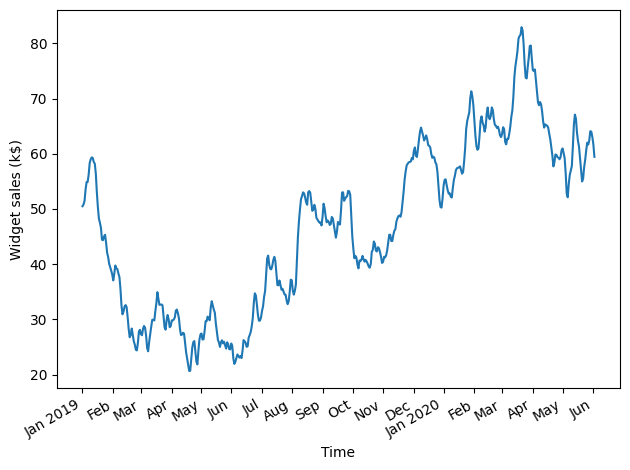

In [3]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

We are going to work with train portion of dataset only since the beginning. Later, we will forecast the test portion and measure the forecast error

In [4]:
train = df['widget_sales'][:int(0.9*len(df['widget_sales']))]
test = df[int(0.9*len(df['widget_sales'])):]

print(len(train))
print(len(test))

450
50


In [5]:
ADF_result = adfuller(train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.2109796621842983
p-value: 0.6688547943380172


In [6]:
widget_sales_diff_train = np.diff(train, n=1)

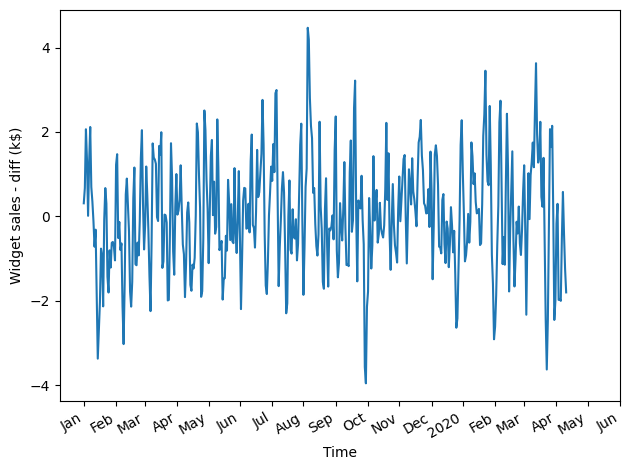

In [7]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff_train)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
ADF_result = adfuller(widget_sales_diff_train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.098597045268312
p-value: 1.0743182765603781e-17


First-order differencing makes it stationary. We could use ARIMA d=1

In [9]:
d = 1

In [10]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [12]:
result_df = optimize_ARIMA(train, order_list, d) # we send the original series, not the differencing
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.431850
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643270


Interesting, ARIMA(3,1,3) would be the best model. ARIMA(0,1,2) is very close. Let's look at ACF and PACF

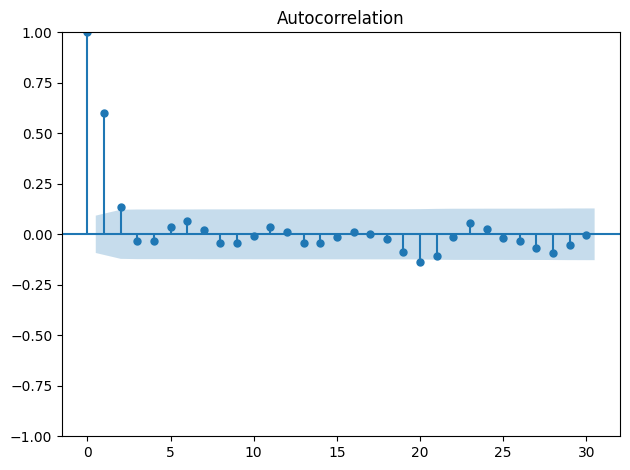

In [13]:
plot_acf(widget_sales_diff_train, lags=30)

plt.tight_layout()

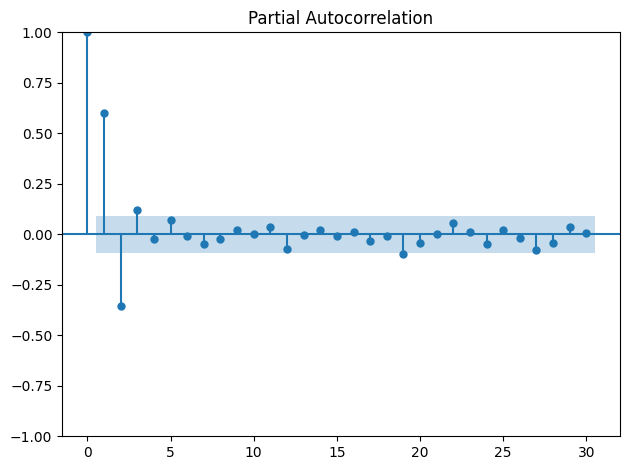

In [14]:
plot_pacf(widget_sales_diff_train, lags=30)

plt.tight_layout()

Both show sinusoidal. And it looks like it would not be ok to ignore the autoregressive portion. Let's try ARIMA(3,1,3). Let's do residual analysis

In [15]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.716
Date:                Sat, 07 Feb 2026   AIC                           1251.432
Time:                        17:24:22   BIC                           1280.181
Sample:                             0   HQIC                          1262.764
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3626      0.064     21.178      0.000       1.237       1.489
ar.L2         -1.3524      0.065    -20.830      0.000      -1.480      -1.225
ar.L3          0.3506      0.064      5.454      0.0

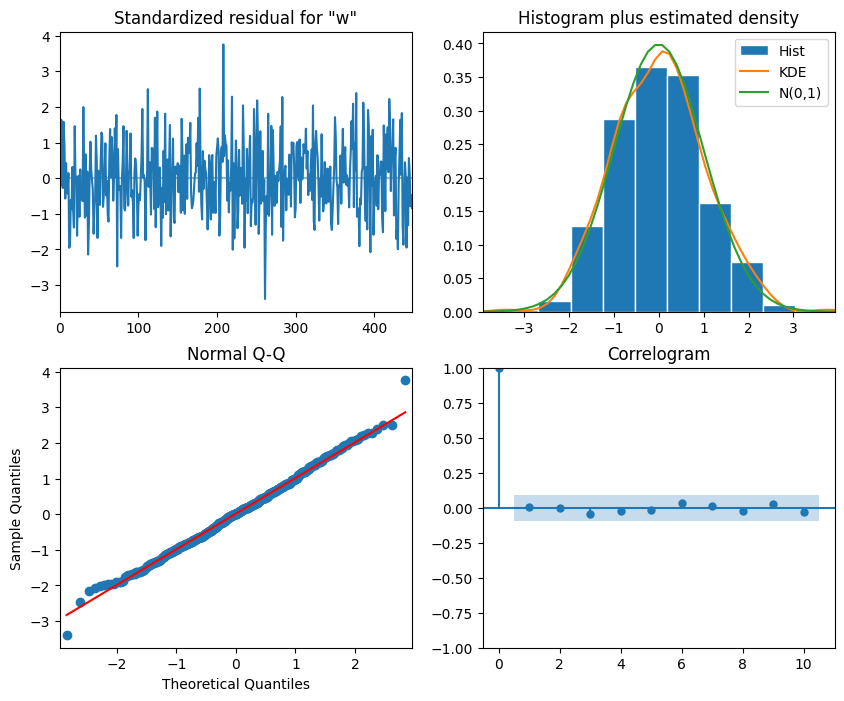

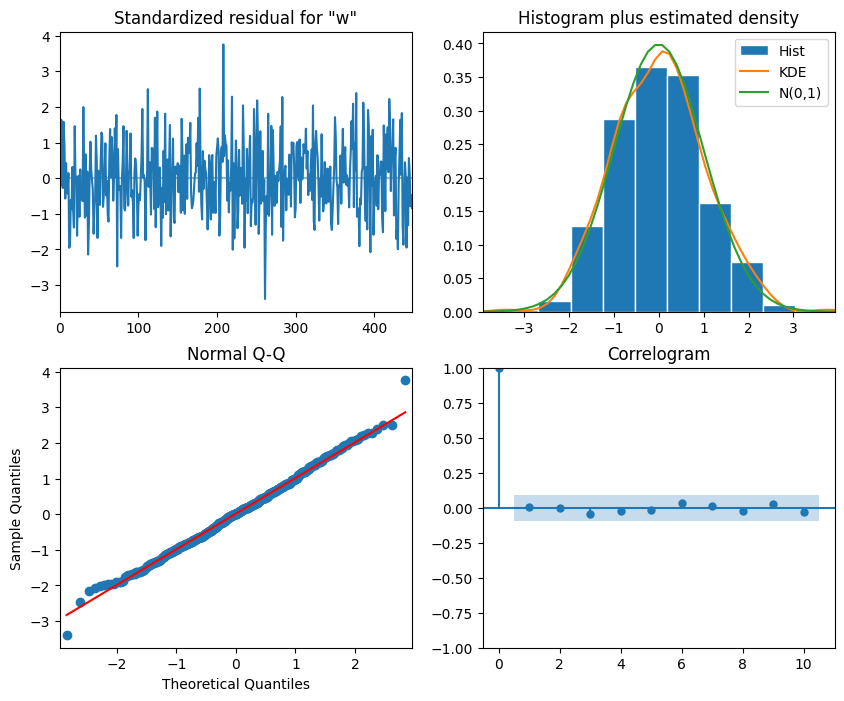

In [16]:
model_fit.plot_diagnostics(figsize=(10,8))

Residuals resemble white noise: normally distributed and uncorrelated

In [17]:
residuals = model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 21, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.017682,0.894213
2,0.045668,0.977425
3,0.241969,0.970546
4,0.263775,0.992031
5,0.284180,0.997930
6,0.704715,0.994389
7,0.828622,0.997141
8,0.903180,0.998789
9,0.953206,0.999538
10,1.003622,0.999825


Residuals are uncorrelated

### Model ready for forecast

In [18]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

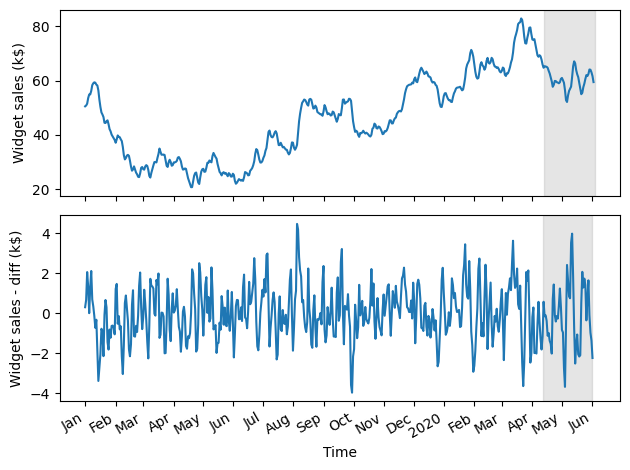

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [20]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(i, i + window - 1)   # changed from (0, i + window - 1) to (i, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [21]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 #2

pred_mean = rolling_forecast(df['widget_sales'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df['widget_sales'], TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARIMA'] = pred_ARIMA

pred_df.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.811520
451,65.316972,45.514944,64.736005,64.576096
452,65.172070,45.558754,65.316972,66.244022
453,65.075506,45.602050,65.172070,64.600264
454,64.703173,45.644943,65.075506,64.994129


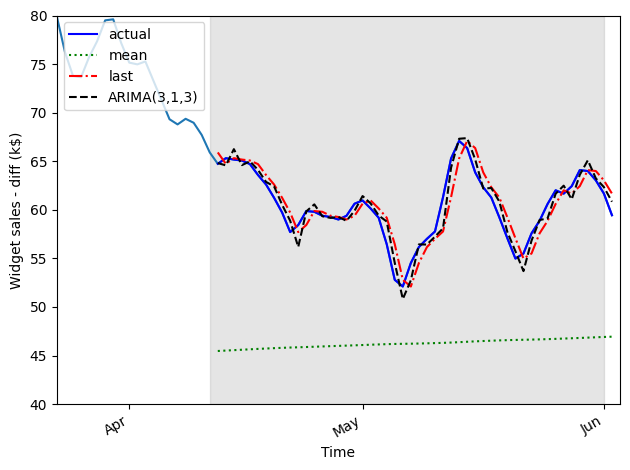

In [28]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.plot(pred_df['widget_sales'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARIMA'], 'k--', label='ARIMA(3,1,3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)
ax.set_ylim(40, 80)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()


In [23]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales'], pred_df['pred_last_value'])
mse_ARIMA = mean_squared_error(pred_df['widget_sales'], pred_df['pred_ARIMA'])

print(mse_mean, mse_last, mse_ARIMA)

214.2263297022068 2.544063859442141 1.1590543316133948


In [25]:
df['pred_widget_sales'] = pred_df['pred_ARIMA']

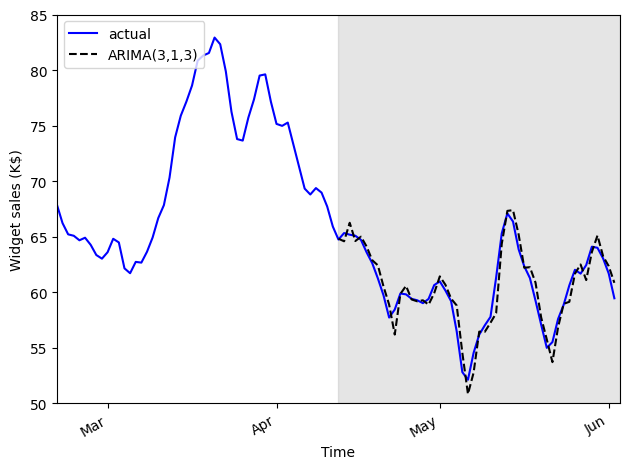

In [30]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='ARIMA(3,1,3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)
ax.set_ylim(50, 85)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [27]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

0.8473593408077411


In Chapter 4 using MA(2) we obtained a Mean Absolute Error of $1,535, here using ARIMA(3,1,3) we got a MAE of $847, almost half.